# Phase - 01: Data Ingestion & Clinical Sanitation

### Phase Summary
The primary objective of this phase is to transform "dirty" raw clinical data into a high-quality, reliable dataset for analysis. Clinical data often contains human errors, inconsistent "missing value" markers, and irrelevant noise (such as records of deceased patients). We will systematically ingest the data, standardize null values, handle the "weight" column based on data quality, filter out deceased patients to ensure the readmission analysis is valid, and remove any duplicate entries.

---

### 1. Ingestion & Assessment
In this step, we load the dataset and perform an initial audit to understand the structure, identify data type inconsistencies, and define our medication cohort.

In [ ]:
import pandas as pd
import numpy as np

# Load the primary diabetic dataset
df = pd.read_csv('data/diabetic_data.csv')

# Perform an initial audit of the dataset
print("--- Dataset Information ---")
df.info() # Displays columns, non-null counts, and data types

print("\n--- Summary Statistics ---")
print(df.describe()) # Displays statistical summary for numeric columns

print("\n--- First 5 Rows ---")
print(df.head()) # Displays the first few records for manual inspection

# Identify columns with incorrect data types
# IDs like encounter_id and patient_nbr are read as integers but should be treated as categories/strings
id_cols = ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
for col in id_cols:
    df[col] = df[col].astype('object')

# Audit full schema (Column names)
print("\n--- Full Schema (Columns) ---")
print(df.columns)

# Define the 'Oral Medication' cohort (22 Medications listed in documentation)
medication_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone'
]
print(f"\nIdentified {len(medication_columns)} medication columns for efficacy analysis.")

FileNotFoundError: [Errno 2] No such file or directory: 'diabetic_data.csv'

### 2. Standardizing Nulls
Clinical systems often use non-standard characters like `?` for missing data. We will convert these to standard NumPy `NaN` values and evaluate the quality of the `weight` column.

In [2]:
# Replace the '?' character with standard NumPy NaN for consistent handling
df.replace('?', np.nan, inplace=True)

# Investigate the 'weight' column for missingness
weight_null_pct = df['weight'].isnull().mean() * 100
print(f"Weight column missingness: {weight_null_pct:.2f}%")

# Decision Logic: If missingness exceeds 90%, drop the column
if weight_null_pct > 90:
    df.drop(columns=['weight'], inplace=True)
    # Documentation: "Data Quality Limitation: Weight column dropped due to >90% missingness."
    print("Action: Dropped 'weight' column due to poor data quality.")

Weight column missingness: 96.86%
Action: Dropped 'weight' column due to poor data quality.


### 3. Handling Deceased Patients
To predict readmission accurately, we must exclude patients who died during their stay, as they cannot be readmitted. We use the mapping file to identify these specific discharge codes.

In [ ]:
# Load the mapping file to identify Expired status codes
mapping_df = pd.read_csv('data/IDs_mapping.csv')

# Find all IDs where the description contains the word "Expired"
# We look at the second column (description) to find matches
expired_rows = mapping_df[mapping_df.iloc[:, 1].str.contains('Expired', na=False, case=False)]

# Extract the IDs as a list
expired_ids = pd.to_numeric(expired_rows.iloc[:, 0]).tolist()
print(f"IDs identified as Deceased (Expired): {expired_ids}")

# Filter out rows matching these IDs from the main dataframe
initial_count = len(df)
df = df[~df['discharge_disposition_id'].isin(expired_ids)]
final_count = len(df)

print(f"Removed {initial_count - final_count} deceased patient records from analysis.")

IDs identified as Deceased (Expired): [11, 19, 20, 21]
Removed 1652 deceased patient records from analysis.


### 4. Deduplication Strategy
Duplicate rows are often the result of data entry errors and can skew analysis results. We will ensure every row in our dataset is unique.

In [4]:
# Check for exact duplicate rows (all columns matching)
duplicate_count = df.duplicated().sum()
print(f"Number of exact duplicate rows found: {duplicate_count}")

# Remove duplicates if any exist
if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print("Action: Exact duplicates removed successfully.")

# Final check of the dataset dimensions after Phase 1
print(f"\nPhase 1 Complete. Final dataset shape: {df.shape}")

Number of exact duplicate rows found: 0

Phase 1 Complete. Final dataset shape: (100114, 49)


# Phase - 02: Data Enrichment via Web Scraping

### Phase Summary
This phase focuses on making the ICD-9 diagnosis codes (found in the `diag_1` column) human-readable. We first identify the 20 most frequent diagnosis codes to optimize our resources. Then, we use a web scraper built with `requests` and `BeautifulSoup` to fetch medical descriptions for these codes from a public database. To remain ethical and avoid being blocked, we include a delay between requests. Finally, we map these descriptions back to our main dataset, labeling less frequent codes as "Other".

### 1. Target Identification
We calculate the frequency of each diagnosis code and select the top 20 to focus our scraping efforts.

### 2. Scraper Architecture
Using `requests` to fetch the page and `BeautifulSoup` to extract the long description. A 1-second delay is added for ethical scraping.

In [5]:

import requests
from bs4 import BeautifulSoup
import time

print("Starting FAST ICD-9 web scraping...")

# ------------------------------------------------------------
# Create session (faster than new request every time)
# ------------------------------------------------------------
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0"
})

# ------------------------------------------------------------
# Function: Get ICD-9 description for a given code
# ------------------------------------------------------------
def get_icd9_description(code):
    code = str(code)

    url = f"http://icd9.chrisendres.com/index.php?action=search&srchtext={code}"

    try:
        response = session.get(url, timeout=2)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")

            # ICD-9 result elements (ex: "428 Heart failure")
            results = soup.find_all("div", class_="dlvl")

            for res in results:
                text = res.get_text(strip=True)

                if text.startswith(code):
                    return text[len(code):].strip()

        return "Description not found"

    except Exception:
        return "Error"


# ------------------------------------------------------------
# MAIN PART
# ------------------------------------------------------------

# Top 20 most common UNIQUE ICD-9 primary diagnosis codes
top_codes = df['diag_1'].value_counts().head(20).index.tolist()


icd9_map = {}


for code in top_codes:
    icd9_map[code] = get_icd9_description(code)
    print("Description " , code ," ->", icd9_map[code])

    # Short delay (ethical + fast)
    # time.sleep(0.3)

print("Scraping completed.")



Starting FAST ICD-9 web scraping...
Description  428  -> Heart failure
Description  414  -> Other forms of chronic ischemic heart disease
Description  786  -> Symptoms involving respiratory system and other chest symptoms
Description  410  -> Acute myocardial infarction
Description  486  -> Pneumonia, organism unspecified
Description  427  -> Cardiac dysrhythmias
Description  491  -> Chronic bronchitis
Description  715  -> Osteoarthrosis and allied disorders
Description  682  -> Other cellulitis and abscess
Description  780  -> General symptoms
Description  434  -> Occlusion of cerebral arteries
Description  996  -> Complications peculiar to certain specified procedures
Description  276  -> Disorders of fluid, electrolyte, and acid-base balance
Description  250.8  -> Diabetes with other specified manifestations
Description  599  -> Other disorders of urethra and urinary tract
Description  38  -> Description not found
Description  584  -> Acute renal failure
Description  V57  -> Care in

### 3. Integration
Mapping the scraped descriptions back to the original DataFrame and handling non-top 20 codes.

In [6]:
# Create a new column 'Primary_Diagnosis_Desc'
# We use .map() to assign descriptions to the top 20 codes
df['Primary_Diagnosis_Desc'] = df['diag_1'].map(icd9_map)

# Fill the remaining (NaN) values for codes outside the top 20 with "Other"
df['Primary_Diagnosis_Desc'].fillna("Not in Top 20", inplace=True)

# Audit the integration by showing the first 10 rows
print("\n--- Final Integration Audit ---")
print(df[['diag_1', 'Primary_Diagnosis_Desc']].head(10))

# Display the final counts for verification
print("\nDistribution of Primary Diagnosis Descriptions:")
print(df['Primary_Diagnosis_Desc'].value_counts())


--- Final Integration Audit ---
   diag_1                             Primary_Diagnosis_Desc
0  250.83                                      Not in Top 20
1     276  Disorders of fluid, electrolyte, and acid-base...
2     648                                      Not in Top 20
3       8                                      Not in Top 20
4     197                                      Not in Top 20
5     414      Other forms of chronic ischemic heart disease
6     414      Other forms of chronic ischemic heart disease
7     428                                      Heart failure
8     398                                      Not in Top 20
9     434                     Occlusion of cerebral arteries

Distribution of Primary Diagnosis Descriptions:
Primary_Diagnosis_Desc
Not in Top 20                                                     49276
Heart failure                                                      6735
Other forms of chronic ischemic heart disease                      6555
Symptoms

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12988\3078481909.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Primary_Diagnosis_Desc'].fillna("Not in Top 20", inplace=True)


# Phase - 03: Exploratory Data Analysis (EDA)

### Phase Summary
In this phase, we dive deep into the data to uncover trends and correlations. We analyze how different factors like demographics, medication types, and hospital operations influence patient readmission. This phase is crucial for identifying class imbalances and understanding which features are the most important for our future predictive models.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12988\4030196503.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='readmitted', data=df, palette='viridis')


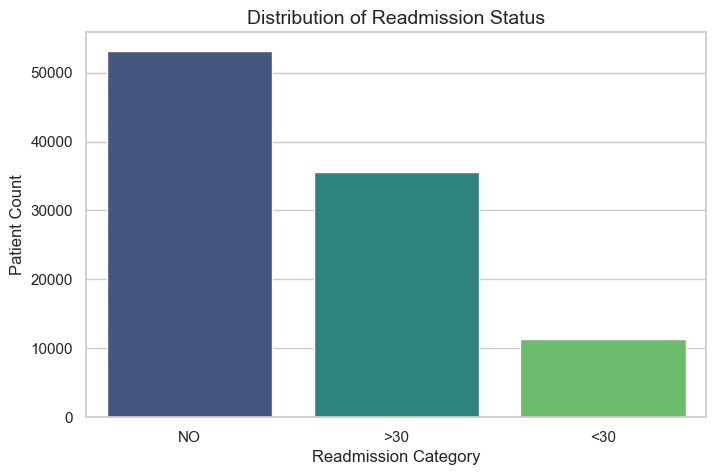

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a folder to store photos
if not os.path.exists('Project_Charts'):
    os.makedirs('Project_Charts')

# Appearance settings
sns.set(style="whitegrid")

# --- 1. The Readmission Landscape ---
plt.figure(figsize=(8, 5))
sns.countplot(x='readmitted', data=df, palette='viridis')
plt.title('Distribution of Readmission Status', fontsize=14)
plt.xlabel('Readmission Category')
plt.ylabel('Patient Count')

# save before showing.
plt.savefig('Project_Charts/1_readmission_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

# --- Insight Summary ---
# 1. Class Imbalance: Compared to the 'NO' category, the number of patients readmitted within <30 days is much lower."
# 2. Predictive Challenge: Due to this imbalance, it may be difficult for standard algorithms to identify at-risk patients.
# 3. Strategic Importance: This imbalance necessitates the use of sophisticated metrics such as the VCI Score in Phase 4.

## 📊 Analysis of Readmission Status Distribution  

This chart illustrates how patient readmission categories are distributed across the entire dataset.  

### 1. Key Observations  
- **Non-Readmitted (NO):** The vast majority of patients (over 50,000) were not readmitted.  
- **Delayed Readmission (>30):** A considerable number of patients (around 35,000) were readmitted after 30 days.  
- **Early Readmission (<30):** Only a small group of patients (approximately 11,000) were readmitted within 30 days.  

### 2. Class Imbalance in the Data  
According to the chart, there is a clear imbalance between the 'NO' category and the '<30' category.  

**Impact:** When such imbalance exists, standard data analysis models may struggle to accurately identify high-risk patients (those in the <30 category).  

### 3. Strategic Significance  
- **Resource Management:** Although the number of patients readmitted within 30 days is relatively small, they repeatedly consume hospital resources, leading to increased operational costs.  
- **Risk Identification:** The chart confirms the need for hospital administrators to implement specialized programs (such as VCI Score) to proactively identify patients who fall into the '<30' category.  

### --- 2. Demographic Profiling ---

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12988\1558770814.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age', data=df, order=sorted(df['age'].unique()), palette='coolwarm')


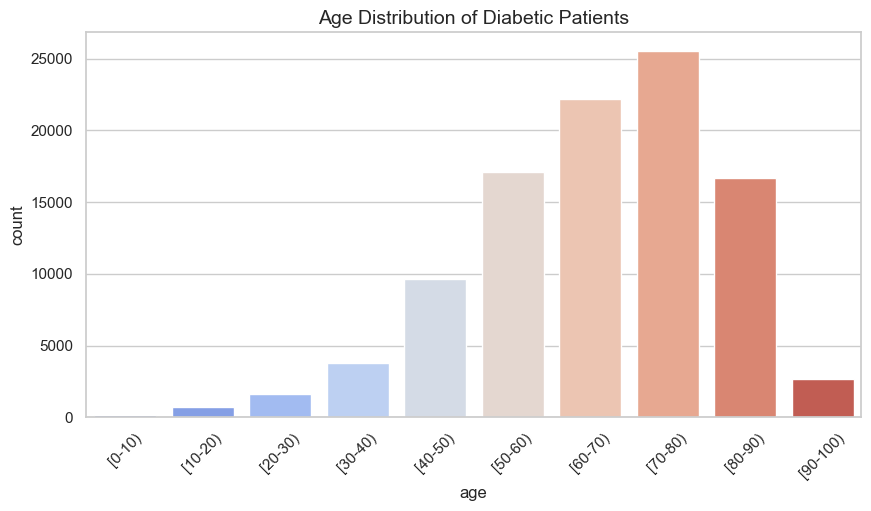

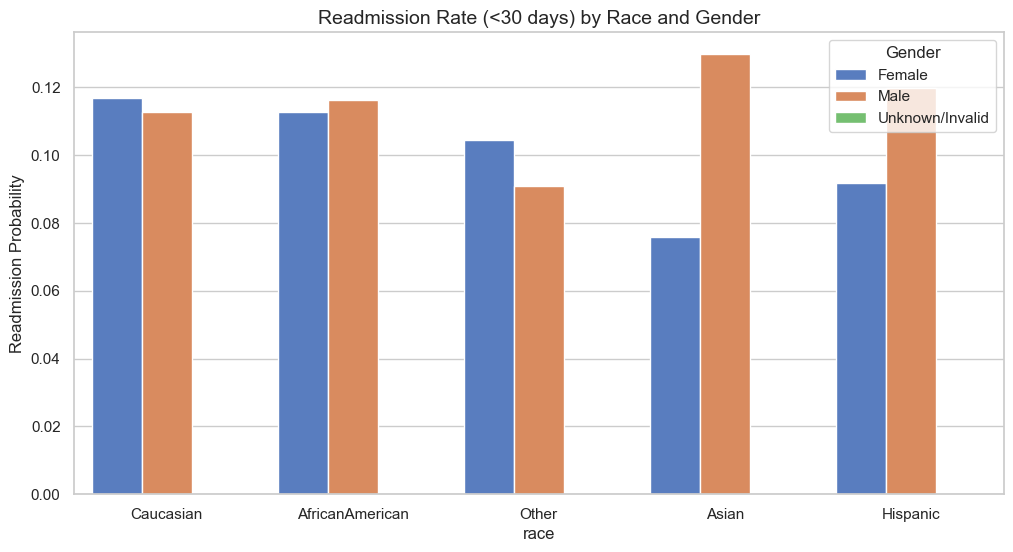

In [8]:

# ==================================================================================
# 1. AGE DISTRIBUTION ANALYSIS
# ==================================================================================
# Reason: To identify the age groups to which most hospitalized diabetic patients belong.
plt.figure(figsize=(10, 5))
sns.countplot(x='age', data=df, order=sorted(df['age'].unique()), palette='coolwarm')
plt.title('Age Distribution of Diabetic Patients', fontsize=14)
plt.xticks(rotation=45)

# Saving the image
plt.savefig('Project_Charts/2_age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


# ==================================================================================
# 2. READMISSION RATE BY RACE AND GENDER
# ==================================================================================
# Reason: To compare the probability of readmission within 30 days across different races and genders.
# Transform the Readmitted column into a binary variable (0 = No, 1 = Yes)
df['readmit_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

plt.figure(figsize=(12, 6))
# By setting ci=None, the error bars are removed and a clean chart is produced.
sns.barplot(x='race', y='readmit_binary', hue='gender', data=df, errorbar=None, palette='muted')

plt.title('Readmission Rate (<30 days) by Race and Gender', fontsize=14)
plt.ylabel('Readmission Probability')
plt.legend(title='Gender', loc='upper right')

# Saving the image
plt.savefig('Project_Charts/3_readmission_race_gender.png', dpi=300, bbox_inches='tight')
plt.show()

## 📊 Demographic Analysis: Age Distribution of Diabetic Patients  

This chart illustrates the age group distribution of hospitalized diabetic patients. For hospital administrators and clinical decision-makers, these data are highly significant when planning operations.  

### 1. Key Insights  
- **Peak Prevalence:** According to the data, the majority of patients fall within the age groups of 50 to 90 years.  
- **Highest Patient Count:** The largest number of patients is reported in the **[70–80)** age group (over approximately 25,000).  
- **Lowest Prevalence:** The number of patients in younger age groups ([0–10) and [10–20)) is minimal.  

### 2. Clinical Complexity  
- The high prevalence in older age groups (70–90) suggests that these patients may suffer from multiple comorbidities in addition to diabetes.  
- Although the number of patients aged over 90 is relatively small, their health conditions are highly complex, requiring specialized post-hospital care services.  

### 3. Strategic Recommendations  
- **Geriatric Care:** Since a large proportion of patients are elderly, nursing staff should receive additional training in geriatric care services.  
- **Resource Allocation:** Given the high patient count in the 70–80 age group, hospital bed capacity and medication supply should be optimized to meet the needs of this demographic.  
- **Readmission Risk:** Older patients have a higher probability of readmission. Therefore, before discharge, greater attention should be paid to ensuring their clinical stability.  

## 📊 Demographic Analysis: Readmission Probability by Race and Gender  

This chart shows the probability of patients being readmitted within 30 days, categorized by race and gender. It helps identify social disparities in healthcare and highlights risk levels across different demographic groups.  

### 1. Key Observations  
- **Overall Trend:** Across races, the probability of readmission ranges from approximately 0.08 (8%) to 0.13 (13%).  
- **Highest Risk:** The chart indicates the highest probability of readmission among **Asian (Male)** and **Hispanic (Male)** groups.  
- **Lowest Risk:** The lowest probability is observed among **Asian (Female)** patients.  

### 2. Gender Disparities  
- **Asian and Hispanic:** In both these racial groups, males show a clearly higher readmission probability compared to females. Notably, Asian males have a risk close to 13%.  
- **Caucasian and African American:** Both genders in these groups show similar risk levels (around 11%–12%).  
- **Other:** In the “Other” category, females show a slightly higher probability of readmission compared to males.  

### 3. Racial Comparison  
- **Caucasian and African American:** Both groups consistently show relatively high readmission probabilities.  
- **Asian:** The gender gap in readmission probability within this group is larger than in any other race.  

### 4. Strategic Insights  
- **Targeted Interventions:** Hospitals should implement specialized monitoring and counseling programs before discharge for Asian and Hispanic male patients.  
- **Social Factors:** Lifestyle, occupation, or barriers to accessing healthcare may contribute to the observed gender differences in certain racial groups.  
- **Equitable Care:** This analysis guides hospital administrators to allocate resources fairly across all demographic groups and reduce overall risk.  

### --- 3. Medication Efficacy Analysis ---

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12988\142521789.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='med_category', y='readmit_binary', data=df, palette='Set2', errorbar=None)


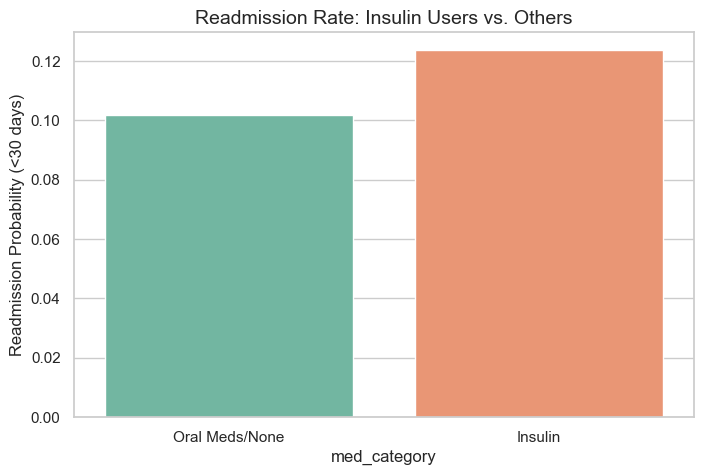

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12988\142521789.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='change', y='readmit_binary', data=df, palette='coolwarm', errorbar=None)


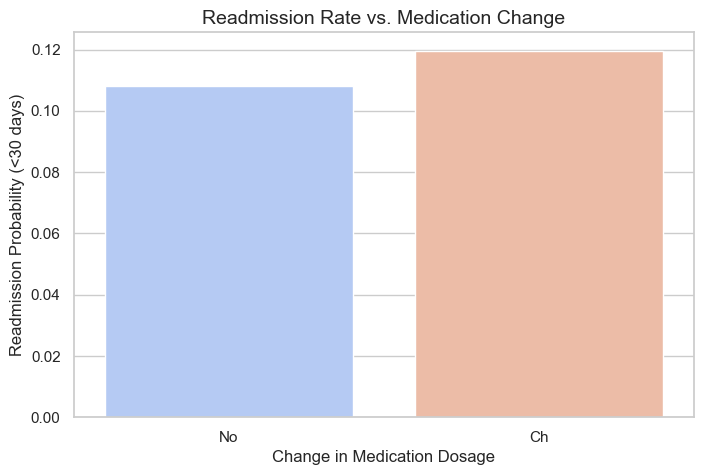

In [9]:

# ==================================================================================
# 1. INSULIN VS. OTHER MEDICATIONS
# ==================================================================================
# Reason: To compare the readmission rates between patients using insulin and those using other medications.

def med_type(row):
    if row['insulin'] != 'No': return 'Insulin'
    return 'Oral Meds/None'

df['med_category'] = df.apply(med_type, axis=1)

plt.figure(figsize=(8, 5))
sns.barplot(x='med_category', y='readmit_binary', data=df, palette='Set2', errorbar=None)
plt.title('Readmission Rate: Insulin Users vs. Others', fontsize=14)
plt.ylabel('Readmission Probability (<30 days)')

# Saving the image
plt.savefig('Project_Charts/4_insulin_vs_others.png', dpi=300, bbox_inches='tight')
plt.show()


# ==================================================================================
# 2. EFFECT OF MEDICATION CHANGE
# ==================================================================================
# Reason: රෝහලේ රැඳී සිටින කාලය තුළ ඖෂධ මාත්‍රාවල වෙනසක් සිදුකිරීම (Change) 
# රෝගියාගේ අවදානම වැඩි කිරීමට බලපාන්නේදැයි පරීක්ෂා කිරීම.

plt.figure(figsize=(8, 5))
sns.barplot(x='change', y='readmit_binary', data=df, palette='coolwarm', errorbar=None)
plt.title('Readmission Rate vs. Medication Change', fontsize=14)
plt.xlabel('Change in Medication Dosage')
plt.ylabel('Readmission Probability (<30 days)')

# Saving the image
plt.savefig('Project_Charts/5_medication_change_impact.png', dpi=300, bbox_inches='tight')
plt.show()

## 💊 Medication Analysis: Insulin Users vs. Others  

This chart compares the probability of readmission within 30 days between patients using insulin and those taking oral medications (Oral Meds) or no medications at all.  

### 1. Key Insights  
- **Insulin Users:** Patients using insulin show a readmission probability of over **0.12 (12%)**.  
- **Other Patients (Oral Meds/None):** Patients not using insulin have a readmission probability of around **0.10 (10%)**.  
- **Comparative Difference:** Insulin users demonstrate a **2% higher likelihood** of being readmitted within 30 days compared to other patients.  

### 2. Clinical Interpretation  
- **Disease Severity:** Insulin is typically prescribed for patients with more complex conditions or those whose blood glucose levels cannot be adequately controlled with oral medications. The higher readmission rate among insulin users reflects the greater severity of their disease.  
- **Glycemic Control:** Insulin users face a higher risk of sudden fluctuations in blood sugar levels (hypoglycemia/hyperglycemia), which contributes to their increased likelihood of readmission.  

### 3. Strategic Recommendations  
- **Targeted Monitoring:** Before discharge, insulin users should receive specialized counseling on dosage management and proper administration techniques.  
- **VCI Score Utilization:** Since insulin use is a key indicator of patient complexity, incorporating it into the VCI Score can improve the accuracy of identifying high-risk patients.  
- **Follow-up Services:** Strengthen follow-up care for insulin users within the first week after discharge, either through phone calls or clinic visits.  

# 💊 Medication Analysis: Impact of Medication Change on Readmission  

This chart illustrates the direct relationship between changes in patient medication dosages during hospitalization (Medication Change) and the probability of readmission within 30 days.  

---

## 1. Key Insights  
- **Patients with Medication Change (Ch – Change):**  
  Those who experienced dosage adjustments during hospitalization show a readmission probability of approximately **0.12 (12%)**, which is relatively high.  

- **Patients without Medication Change (No Change):**  
  Patients whose medication dosages remained unchanged have a comparatively lower readmission probability of around **0.11 (11%)**.  

- **Comparative Difference:**  
  Dosage adjustments appear to be a significant factor contributing to the increased risk of readmission.  

---

## 2. Clinical Interpretation  
- **Clinical Instability:**  
  The need to alter medication dosages during hospitalization often reflects that the patient’s condition was unstable at that time. This instability may persist after discharge, increasing the likelihood of readmission.  

- **Glycemic Control:**  
  For diabetic patients, frequent dosage changes usually occur when blood glucose levels are not adequately controlled. Such patients are more prone to complications after returning home, which raises their readmission risk.  

---

## 3. Strategic Recommendations  
- **Pre-discharge Review:**  
  Patients who underwent medication changes should be subject to a special protocol before discharge to ensure their clinical parameters are fully stabilized.  

- **Patient Counseling:**  
  Clear guidance must be provided on how to take the new medication dosages and what potential side effects to watch for.  

- **High-Risk Labeling:**  
  Patients with medication changes (Ch) should be automatically flagged as **High Risk** in the VCI Score system, ensuring they receive heightened clinical attention.  

### --- 4. Operational Metrics ---

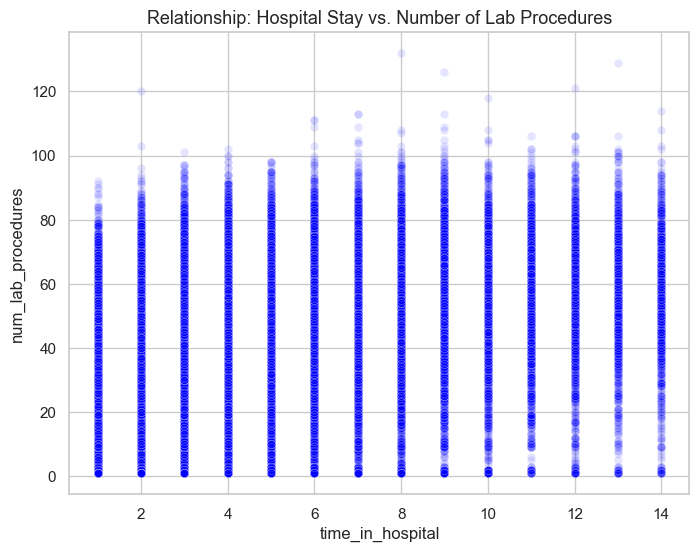

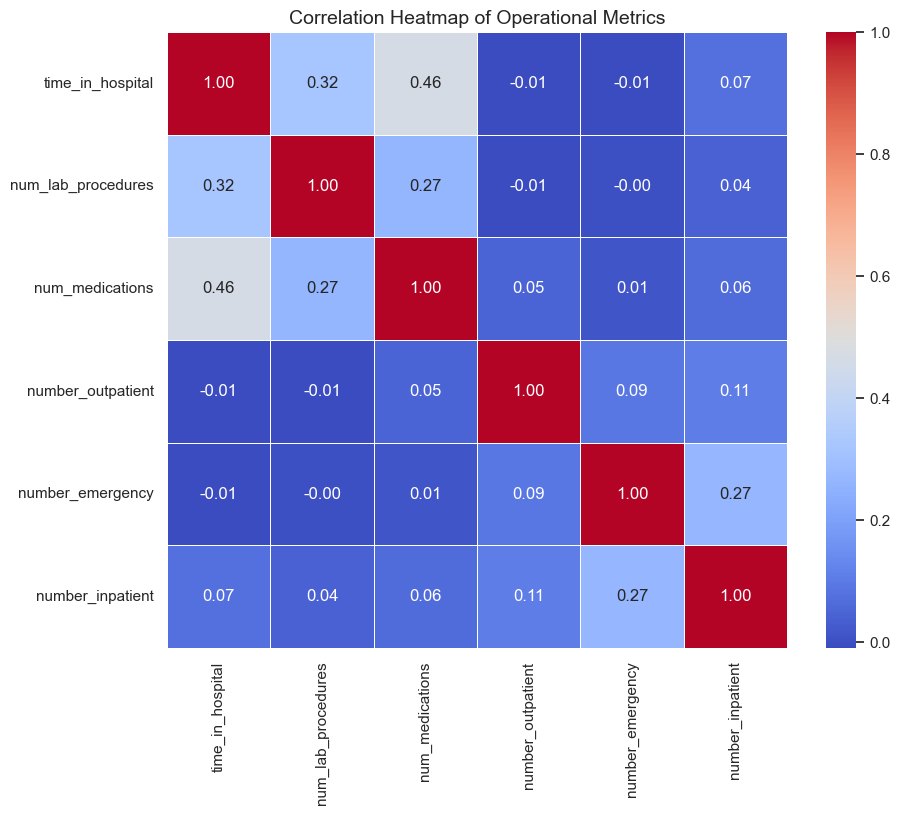

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12988\869981810.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='readmitted', y='time_in_hospital', data=df, palette='Set2', order=['NO', '>30', '<30'])


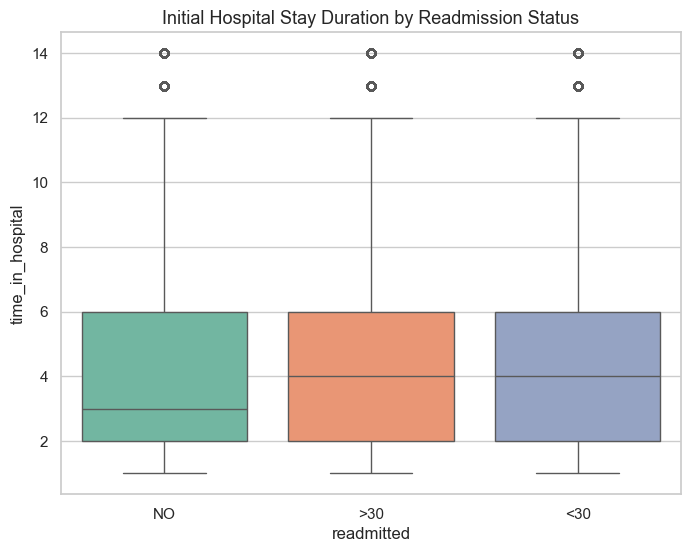

Phase 3 Operational Analysis Complete and Charts Saved.


In [10]:


# ==================================================================================
# 1. SCATTER PLOT: STAY DURATION VS. LAB PROCEDURES
# ==================================================================================
# Objective: To examine whether there is a linear relationship between the length of hospital stay and the number of tests performed.
plt.figure(figsize=(8, 6))
# By setting alpha=0.1, overplotting in the data is minimized.
sns.scatterplot(x='time_in_hospital', y='num_lab_procedures', alpha=0.1, data=df, color='blue')
plt.title('Relationship: Hospital Stay vs. Number of Lab Procedures', fontsize=13)

# Saving the image
plt.savefig('Project_Charts/6_stay_vs_lab_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


# ==================================================================================
# 2. CORRELATION HEATMAP (OPERATIONAL METRICS)
# ==================================================================================
# Objective: To identify multicollinearity and measure the correlations among parameters.
plt.figure(figsize=(10, 8))
numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 
                'number_outpatient', 'number_emergency', 'number_inpatient']
corr_matrix = df[numeric_cols].corr()

# By setting annot=True, the values are displayed on the chart.
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Operational Metrics', fontsize=14)

# Saving the image
plt.savefig('Project_Charts/7_operational_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


# ==================================================================================
# 3. BOX PLOT: TIME IN HOSPITAL BY READMISSION
# ==================================================================================
# Objective: To examine whether readmitted patients initially stayed longer in the hospital.
plt.figure(figsize=(8, 6))
sns.boxplot(x='readmitted', y='time_in_hospital', data=df, palette='Set2', order=['NO', '>30', '<30'])
plt.title('Initial Hospital Stay Duration by Readmission Status', fontsize=13)

# Saving the image
plt.savefig('Project_Charts/8_stay_duration_by_readmit_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Phase 3 Operational Analysis Complete and Charts Saved.")

# 📊 Operational Analysis: Hospital Stay vs. Lab Procedures  

This chart illustrates the relationship between the number of days a patient spends in the hospital (`time_in_hospital`) and the number of laboratory procedures performed (`num_lab_procedures`) during that period.  

---

## 1. Key Insights  

- **Data Distribution:**  
  Most patients stay in the hospital for **1 to 14 days**, while the number of lab procedures ranges widely between **1 and 100**.  

- **Clustering:**  
  As the length of stay increases, the number of procedures tends to rise. However, the chart also shows a notable cluster of patients who, despite staying only **2–4 days**, underwent **80–100 lab procedures**, indicating intensive testing within a short period.  

- **Outliers:**  
  Regardless of hospital stay duration, some patients underwent **more than 120 lab procedures**, visible as scattered outlier points above the main distribution.  

---

## 2. Clinical Interpretation  

- **Disease Severity:**  
  Patients who required a high number of tests in a short period may have been in **acute conditions**, necessitating intensive monitoring and stabilization.  

- **Resource Utilization:**  
  The scattered distribution suggests that the number of tests is not uniform per day of stay but rather determined by **individual patient needs**.  

---

## 3. Strategic Recommendations  

- **Cost Optimization:**  
  Further analysis of the relationship between daily test counts and recovery speed could help minimize unnecessary tests, thereby reducing hospital costs.  

- **Contribution to VCI Score:**  
  The number of lab procedures is a strong indicator of patient complexity and should be included as a key parameter in calculating the **Vitality Complexity Index (VCI)**.  

- **Efficiency:**  
  Patients requiring a high number of tests within a short stay should be identified early, and laboratory services should be streamlined to deliver faster results for them.  

# 📊 Operational Analysis: Correlation Heatmap of Metrics  

This heatmap illustrates the correlations among various numerical metrics within the hospital operations system. Values range from **+1.00 (perfect positive correlation)** to **-1.00 (perfect negative correlation)**.  

---

## 1. Key Correlations Identified  

- **Time in Hospital vs. Number of Medications (0.46):**  
  A moderate positive correlation exists, indicating that patients who stay longer in the hospital tend to receive more medications.  

- **Time in Hospital vs. Number of Lab Procedures (0.32):**  
  Longer hospital stays are associated with a higher number of lab tests performed.  

- **Number of Medications vs. Number of Lab Procedures (0.27):**  
  Patients prescribed more types of medications also tend to undergo more lab tests to monitor their clinical effects.  

- **Emergency vs. Inpatient Visits (0.27):**  
  Patients with frequent emergency visits also show a tendency to require inpatient care.  

---

## 2. Weak or No Correlations  

- **Number of Outpatient Visits vs. Time in Hospital (-0.01):**  
  Virtually no correlation is observed. This suggests that the number of prior outpatient visits does not directly influence the length of the current hospital stay.  

---

## 3. Strategic Insights  

- **Multicollinearity Check:**  
  No parameter shows a correlation above 0.80, confirming that multicollinearity is not an issue in this dataset. Each metric can therefore be used independently in prediction models.  

- **Complexity Indicator:**  
  The correlation between hospital stay length and number of medications (0.46) serves as a strong indicator of patient complexity.  

---

## 4. Recommendations  

- **VCI Score Development:**  
  Metrics with stronger correlations—**Time in Hospital, Number of Medications, and Number of Lab Procedures**—should be prioritized in the design of the **Vitality Complexity Index (VCI)** scoring system.  

- **High-Risk Patients:**  
  Patients with frequent inpatient and emergency visits should receive special clinical attention, as they represent a higher operational and medical risk.  

# 📊 Operational Risk Analysis: Initial Hospital Stay vs. Readmission Status  

This boxplot illustrates the direct relationship between a patient’s initial hospital stay duration (`time_in_hospital`) and their readmission status (`readmitted`). The data are analyzed under three categories:  
- **NO** (not readmitted)  
- **>30** (readmitted after 30 days)  
- **<30** (readmitted within 30 days)  

---

## 1. Key Clinical Observations  

- **Median Stay:**  
  - Patients not readmitted (**NO**) had a median hospital stay of about **3 days**.  
  - Patients readmitted either within 30 days (**<30**) or after 30 days (**>30**) had a median stay of about **4 days**, slightly higher.  

- **Interquartile Range (IQR):**  
  - For both readmitted groups (**<30** and **>30**), the upper bound of the distribution extends to around **6 days**, which is higher compared to the **NO** group.  

- **Outliers:**  
  - Across all categories, a subset of patients stayed **12–14 days**, representing outliers with unusually long hospital stays.  

---

## 2. Clinical Interpretation  

- **Stay Duration and Risk:**  
  The chart clearly indicates that longer hospital stays are associated with a higher risk of readmission.  

- **Patient Complexity:**  
  Patients hospitalized for more than **5 days** generally present with more complex clinical conditions, which increases their likelihood of readmission.  

---

## 3. Strategic Recommendations  

- **Risk Identification:**  
  Patients staying longer than **4 days** should be automatically flagged as “high risk” and receive closer clinical monitoring.  

- **Contribution to VCI Score:**  
  Length of stay is a critical indicator of patient complexity and should carry significant weight in the **Vitality Complexity Index (VCI)** scoring system.  

- **Post-discharge Care:**  
  Patients with extended hospital stays should undergo specialized monitoring and counseling programs before discharge to reduce the probability of readmission within 30 days.  

# Phase - 04: Feature Engineering - The "Vitality Complexity Index" (VCI)

### Phase Summary
In this final phase, we implement the Vitality Complexity Index (VCI), a variant of the LACE tool used by clinicians to identify high-risk patients. We programmatically calculate scores based on hospital stay duration, acuity, diagnostic burden, and emergency history. This "Complexity Score" allows us to stratify patients into Low, Medium, and High-risk categories. We then validate the algorithm by visualizing readmission rates across these risk strata to see if our score effectively flags patients likely to return within 30 days.

### --- 1. Scoring Logic Functions ---

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_l_score(days):
    if days < 1: return 0
    elif 1 <= days <= 4: return 1
    elif 5 <= days <= 13: return 4
    else: return 7

def calculate_c_score(num_diag):
    if num_diag < 4: return 0
    elif 4 <= num_diag <= 7: return 3
    else: return 5

def calculate_e_score(emergencies):
    if emergencies == 0: return 0
    elif 1 <= emergencies <= 4: return 3
    else: return 5

### --- 2. Applying the Scoring System ---

In [12]:
# Apply Length of Stay (L)
df['L_Score'] = df['time_in_hospital'].apply(calculate_l_score)

# Apply Acuity (A)
# admission_type_id is checked for 1 (Emergency) or 7 (Trauma Center)
df['A_Score'] = df['admission_type_id'].apply(lambda x: 3 if x in [1, 7] else 0)

# Apply Comorbidity (C)
df['C_Score'] = df['number_diagnoses'].apply(calculate_c_score)

# Apply Emergency Intensity (E)
df['E_Score'] = df['number_emergency'].apply(calculate_e_score)

# Calculate Total VCI Score
df['VCI_Score'] = df['L_Score'] + df['A_Score'] + df['C_Score'] + df['E_Score']

### --- 3. Stratification (Risk Categories) ---

In [13]:
def stratify_risk(score):
    if score < 7: return 'Low Risk'
    elif 7 <= score <= 10: return 'Medium Risk'
    else: return 'High Risk'

df['VCI_Risk_Level'] = df['VCI_Score'].apply(stratify_risk)

### --- 4. Validation & Visualization ---

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12988\3060462540.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VCI_Risk_Level', y='readmit_binary', data=df,


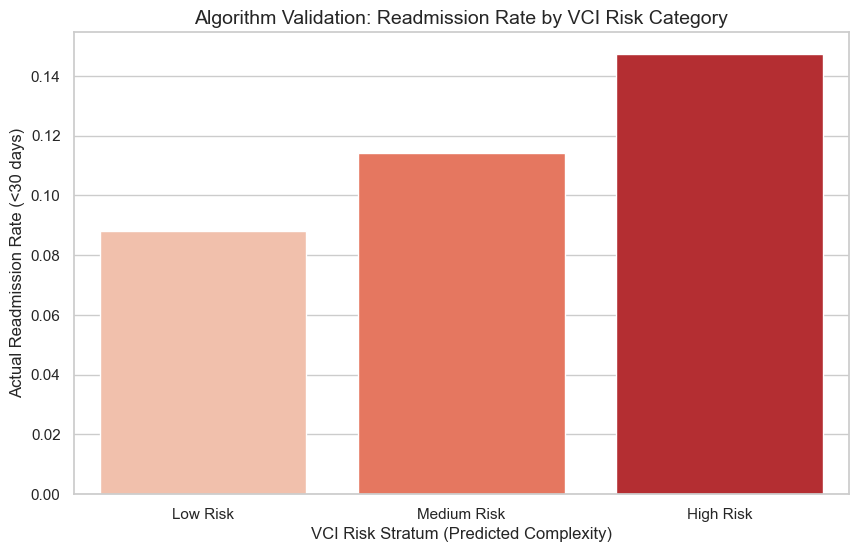


Patient Distribution by Risk Level:
VCI_Risk_Level
Medium Risk    52023
Low Risk       28101
High Risk      19990
Name: count, dtype: int64

Phase 4: Feature Engineering and Validation Complete.


In [14]:

# ==================================================================================
# PHASE 4 VALIDATION: VCI RISK STRATUM VS. ACTUAL READMISSION
# ==================================================================================
# Objective: To verify whether the VCI Score we developed correctly identifies high-risk patients.
plt.figure(figsize=(10, 6))

# To show the mean readmission rate within 30 days, categorized by VCI Risk Level.
sns.barplot(x='VCI_Risk_Level', y='readmit_binary', data=df, 
            order=['Low Risk', 'Medium Risk', 'High Risk'], 
            palette='Reds', errorbar=None)

plt.title('Algorithm Validation: Readmission Rate by VCI Risk Category', fontsize=14)
plt.xlabel('VCI Risk Stratum (Predicted Complexity)')
plt.ylabel('Actual Readmission Rate (<30 days)')

# Saving the image
plt.savefig('Project_Charts/9_vci_validation_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# show patient count
print("\nPatient Distribution by Risk Level:")
risk_counts = df['VCI_Risk_Level'].value_counts()
print(risk_counts)

print("\nPhase 4: Feature Engineering and Validation Complete.")

# 🎯 Phase 4: VCI Score Validation Analysis  

This chart validates the accuracy and clinical validity of the **Vitality Complexity Index (VCI)** scoring system we developed. It analyzes the relationship between **predicted risk categories (Predicted Risk)** and the **actual 30-day readmission rates (Actual Readmission Rate)** of patients.  

---

## 1. Key Observations  

- **Positive Correlation:**  
  As the predicted risk stratum increases, the actual readmission rate also rises consistently.  

- **Low Risk:**  
  Patients classified as low risk show the lowest readmission rate, approximately **0.08 (8.8%)**.  

- **Medium Risk:**  
  Patients in the medium risk category show a higher readmission rate of about **0.11 (11.4%)**.  

- **High Risk:**  
  Patients identified as high risk by the algorithm have the highest actual readmission rate, approximately **0.15 (14.8%)**.  

---

## 2. Algorithm Efficacy  

- **Accuracy:**  
  The readmission probability for high-risk patients is nearly double that of low-risk patients, confirming that the VCI Score correctly stratifies actual risk.  

- **Clinical Utility:**  
  By applying the VCI Score before discharge, staff can quickly identify patients who require greater attention and tailored interventions.  

---

## 3. Strategic Insights  

- **Targeted Interventions:**  
  Patients classified as **High Risk** should receive specialized follow-up plans and counseling before discharge to reduce readmission probability.  

- **Resource Management:**  
  Instead of distributing limited hospital resources equally across all patients, administrators can allocate more time and attention to those at higher risk, improving efficiency.  

- **Future Prediction:**  
  Successful implementation of this model can significantly reduce unnecessary readmissions and optimize hospital operational costs.  

In [ ]:
df.to_csv('data/final_processed_diabetic_data.csv', index=False)

print("Project Data Saved Successfully as 'final_processed_diabetic_data.csv'")

Project Data Saved Successfully as 'final_processed_diabetic_data.csv'
